$$U_{+} |i\rangle = \left\{ \begin{array}{l l} |i+1\rangle & {\text{if } } i\neq 2^{N-1}\ |0\rangle & {\text{if } } i = 2^{N-1} \end{array} \right\}$$ 

In a matrix form this is simply the matrix 

$$ U_+ = \begin{pmatrix} 0 & 1 & 0 & \cdots & 0 & 0 \\ 0 & 0 & 1 & 0 & \cdots & 0 \\ 0 & \ddots &\ddots & \ddots & \cdots & 0 \\ \vdots & \ddots & \ddots & \ddots& \ddots & \vdots \\ 0 & \ddots & \ddots & 0& 0 & 1 \\ 1 & 0 & 0 & \cdots & 0 & 0 \end{pmatrix}. $$ 

In Fourier space this matrix is diagonal, namely, the Fourier matrix $$\mathcal{FT} $$ diagonalizes it. Moreover, the diagonal entries forms a goemetric series: 

$$ U_+ = \mathcal{FT} \cdot \begin{pmatrix} \alpha^0 & 0 & \cdots& \cdots & 0 \\ 0 & \alpha^1 & 0 & \cdots & 0 \\ 0 & 0 &\ddots & \cdots & 0 \\ 0 & 0 &\cdots & \alpha^{2^N-2} & 0 \\ 0 & \cdots & 0 & \cdots & \alpha^{2^N-1} \end{pmatrix} \cdot \mathcal{FT}^{\dagger} $$

In [2]:
from classiq import *
import networkx as nx
import matplotlib.pyplot as plt

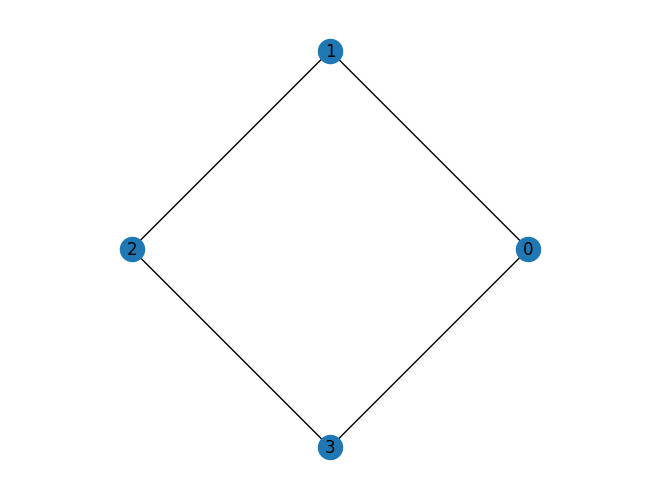

In [8]:
size = 2

edge_list = [(i, (i+1)%(2**size)) for i in range(2**size)]

G = nx.Graph(edge_list)

nx.draw_circular(G, with_labels=True)
plt.axis('equal')
plt.show()

In [9]:
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0,0,0,0]
    prob[(i+1)% 4]=0.5
    prob[(i-1)% 4]=0.5
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      C_iteration(i,vertices,adjacent_vertices)


@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1)


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  C_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)
results = execute(qprog).result()

State=0, prob vec =[0, 0.5, 0, 0.5]
State=1, prob vec =[0.5, 0, 0.5, 0]
State=2, prob vec =[0, 0.5, 0, 0.5]
State=3, prob vec =[0.5, 0, 0.5, 0]
Opening: https://platform.classiq.io/circuit/0bef61e3-2db4-4669-b756-1e658878b8ca?version=0.43.3


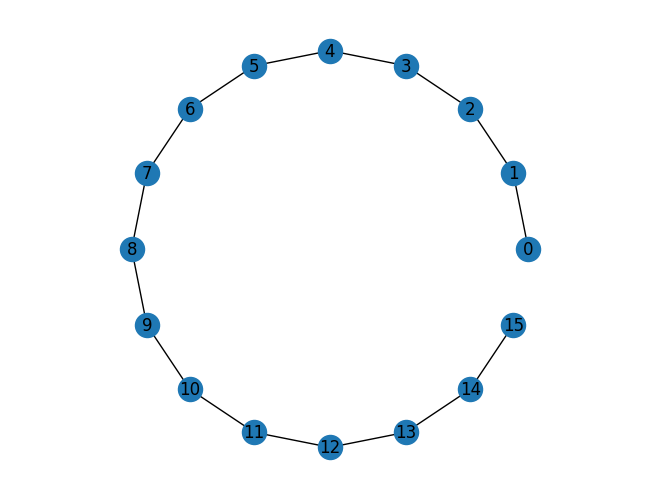

In [6]:
size = 4

edge_list = [(i, i+1) for i in range(2**size-1)]

G = nx.Graph(edge_list)

nx.draw_circular(G, with_labels=True)
plt.axis('equal')
plt.show()

In [ ]:
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(aux: QNum,x: QNum):
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)


def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum, aux: QNum):
    prob = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    if i != 0 and i != 15:
        prob[i+1]=0.5
        prob[i-1]=0.5
    elif i == 0:
        prob[i+1] = 1
    else:
        prob[i-1] = 1
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(aux,adjacent_vertices)))


@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    aux = QNum('aux')
    allocate(1, aux)
    for i in range(2**size):
      C_iteration(i,vertices,adjacent_vertices,aux)


@qfunc
def edge_oracle(adj_l:Output[QNum],adj_r:Output[QNum], vertices: QNum, adjacent_vertices: QNum):
    adj_l |= ((vertices-adjacent_vertices) ==1)
    adj_r |= ((adjacent_vertices-vertices) ==1)


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    adj_l = QNum('adj_l')
    adj_r = QNum('adj_r')
    edge_oracle(adj_l,adj_r,vertices,adjacent_vertices)
    control(ctrl= adj_l==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))
    control(ctrl= adj_r==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)
  #hadamard_transform(adjacent_vertices)

  C_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
quantum_model_with_constraints = set_constraints(
    qmod, Constraints(optimization_parameter="width", max_depth=10000)
)
qprog = synthesize(quantum_model_with_constraints)
show(qprog)
results = execute(qprog).result()